# Mod 4 Project: Zillow Housing Data Time Series Modeling & Forecasting

Student: Doug Steen

Instructor: James Irving, PhD

Cohort: ds_ft_10072019

Project Review Date: ______________

## Background & Purpose

A fictional real estate investment company has requested assistance with the following question:

- What are the five best zip codes to invest in?

For this study, I am using a Zillow Housing Dataset, obtained from Zillow's research page (https://www.zillow.com/research/data/). The raw dataset is located in this repository ('zillow_data.csv'). This dataset contains monthly average home values for nearly every zip code in the U.S., with most zip codes having data from 1996 - 2018.

### Target Region: Tarrant County, TX

The scope of this analysis is limited to the zip codes in Tarrant County, Texas which have available measurements for the full data range (1996 - 2018). Tarrant County encompasses the western portion of the Dallas-Fort Worth (DFW) Metroplex, and most notably contains the cities of Fort Worth and Arlington.
    
### Method

Modeling and forecasting of home values using ARIMA (Auto-regressive Integrated Moving Average) time series analysis techniques.

### Selection Criteria:

The five 'best' zip codes for investment in Tarrant County will be selected based on the following criteria:
    
-3 year forecasted return on investment (ROI)
    
-Confidence interval of the ROI forecast
    
-Quality of model prediction using a train-test split of Zillow data



## Import Libraries / Packages

In [1]:
# Import cohort package
#!pip install -U fsds_100719
from fsds_100719.imports import *
import itertools
import statsmodels.api as sm
from tqdm import tqdm_notebook

# Display all columns of large dataframes
pd.set_option('display.max_columns',0)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set default plot style
plt.style.use('seaborn-darkgrid')
%matplotlib inline

fsds_1007219  v0.6.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


## Functions

In [2]:
def melt_data(df): #formerly called it melt_data_student with REED
   
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    
    return melted


def arima_grid_search(df, zip_code, pdq_range = range(0,4), seasonal=False, train_test=True, 
                      train_end='2015-04', show_iters=False):

    # Define the p, d and q parameters to take any value within the specified range
    p = d = q = pdq_range
    
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p,d,q))
    
    # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)
    
    # If arima model is being fit as part of a train-test split, define correct training interval
    if train_test:
            ts_zip = ts_zip[:train_end]
    
    results = []
    
    if seasonal == False:
        for i in tqdm_notebook(pdq, desc=f'{zip_code} Grid Search Progress'):
            model = sm.tsa.SARIMAX(ts_zip, order=i,enforce_stationarity=False,
                                         enforce_invertibility=False)
            out = model.fit()
            aic = out.aic
            results.append([i, aic])
            if show_iters == True:
                print([i, aic])
        results_df = pd.DataFrame(results, columns=['pdq', 'aic'])
        min_result = results_df.loc[results_df['aic'].idxmin()]
        return zip_code, min_result
    else:
        pdqs = [(x[0], x[1], x[2], 12) for x in pdq]
        for i in tqdm_notebook(pdq, desc=f'{zip_code} Grid Search Loop Progress'):
            for j in tqdm_notebook(pdqs, desc=f'{zip_code} Grid Search Sub-Loop Progress'):
                model = sm.tsa.SARIMAX(ts_zip, order=i, seasonal_order=j, enforce_stationarity=False,
                                         enforce_invertibility=False)
                out = model.fit()
                aic = out.aic
                results.append([i, j, aic])
                if show_iters == True:
                    print([i, j, aic])
        results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
        min_result = results_df.loc[results_df['aic'].idxmin()]
        return zip_code, min_result
    

def predict_arima(df, zip_code, train_end, test_begin, test_end, pdq, plot=False):
    """Fits an ARIMA model to training data and makes a prediction on testing data for a given zip code. Returns MAPE
    and R^2 of model test predictions.
    
    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing desired time series data for all zip codes
    zip code : int
        Desired zip code for model fit and prediction
    train_end : str
        Date to signify end of training (model fit) portion (Assumed that training data is at beginning of ts)
    test_begin : str
        Date to signify beginning of test portion (Model predictions will begin with this date to end of time series)
    test_end : str
        Date to signify end of test portion (Model predictions will end with this date in time series)
    pdq : tuple
        Tuple of the form (p, d, q) to serve as ARIMA model parameters
    plot : bool
        If True, returns plot of time series and model prediction with 95% conf interval
        (Default = False)
    
    Returns
    -------
    
    """
    import statsmodels.api as sm
    from sklearn.metrics import r2_score
    
    # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)
    
    # Define train and test subsets of time series
    ts_zip_train = ts_zip.loc[:train_end]
    ts_zip_test = ts_zip.loc[test_begin:]
    
    mod = sm.tsa.SARIMAX(ts_zip_train, order=pdq, enforce_stationarity=False,
                                 enforce_invertibility=False)

    output = mod.fit()
    
    # Get predictions for test portion of data
    pred_test = output.get_prediction(start=test_begin, end=test_end)
    pred_conf = pred_test.conf_int()
    
    # Model prediction performance on test data
    y_hat_test = pred_test.predicted_mean.values

    y_test = ts_zip_test.values.ravel()
    
    # Creating train-test prediction plot with conf interval if plot is selected
    if plot == True:
        
        plt.rcParams["figure.figsize"] = [8,5]
        ax = ts_zip.plot(color='black')
        pred_test.predicted_mean.plot(ax=ax, label='Test Prediction', alpha=.9, color='red')
        ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='red', alpha=.1, label='95% Conf. Int.')
        ax.set_xlabel('Date')
        ax.set_ylabel('Mean Home Value ($)')
        plt.legend(loc=2)
        plt.title(f'Model Prediction for {zip_code}: {test_begin} - {test_end}')
        plt.show();
        
    # MAPE : Mean Absolute Percentage Error
    mape = round(np.sum(abs((np.subtract(y_test, y_hat_test) / y_test))) / len(y_test), 3)

    # R^2 Score
    r2 = round(r2_score(y_test, y_hat_test), 3)

    model_val_summary = pd.DataFrame(columns = ['Zip Code', 'MAPE (%)', 'R^2'])

    model_val_summary = model_val_summary.append({'Zip Code': str(zip_code), 'pdq': pdq, 
                                                  'MAPE (%)': mape*100, 'R^2': r2}, ignore_index=True)

    return model_val_summary

def forecast_arima(df, zip_code, forecast_begin, forecast_end, pdq, plot=False):
    
    import statsmodels.api as sm
    
     # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)
    
    ts_zip.index = pd.DatetimeIndex(ts_zip.index.values,
                               freq='MS')
    
    # Generate forecast arima model object
    fc_model = sm.tsa.SARIMAX(ts_zip, order=pdq, enforce_stationarity=False,
                                 enforce_invertibility=False)
    
    # Fit model
    fc_output = fc_model.fit()
    
    # Obtain model forecast for desired time period, and confidence interval
    forecast = fc_output.get_prediction(start=forecast_begin, end=forecast_end)
    fc_conf = forecast.conf_int()
    
    # Creating forecast plot with conf interval if plot is selected
    if plot == True:
        
        plt.rcParams["figure.figsize"] = [8,5]
        ax = ts_zip.plot(color='black')
        forecast.predicted_mean.plot(ax=ax, label='Forecast Prediction', alpha=.9, color='green')
        ax.fill_between(fc_conf.index,
                fc_conf.iloc[:, 0],
                fc_conf.iloc[:, 1], color='green', alpha=.1, label='95% Conf. Int.')
        ax.set_xlabel('Date')
        ax.set_ylabel('Mean Home Value ($)')
        plt.legend(loc=2)
        plt.title(f'Model Forecast for {zip_code}: {forecast_begin} - {forecast_end}')
        plt.show();
    
    # Calculate 3 year ROI for the forecast
    # Initial value
    init_val = ts_zip.values[-1]

    # Final forecasted value after 3 year forecast
    f_val = forecast.predicted_mean[-1]

    ROI = np.round(((f_val - init_val) / init_val)[0], 3)

    # Calculate lower & upper 95% confidence ROI values

    # lower bound
    l_f_val = fc_conf['lower MeanValue'][-1]

    low_ROI = np.round(((l_f_val - init_val) / init_val)[0], 3)

    # upper bound
    u_f_val = fc_conf['upper MeanValue'][-1]

    high_ROI = np.round(((u_f_val - init_val) / init_val)[0], 3)

    # Size of 95% CL

    size_cl = np.round(high_ROI - low_ROI, 3)

    ROI_summary = pd.DataFrame(columns = ['Zip Code', 'Forecast ROI (%)', 'L 95 ROI (%)', 'H 95 ROI (%)', '95 CL Size (%)'])

    ROI_summary = ROI_summary.append({'Zip Code': str(zip_code), 'Forecast ROI (%)': ROI*100, 'L 95 ROI (%)': low_ROI*100, 
                                      'H 95 ROI (%)': high_ROI*100, '95 CL Size (%)': size_cl*100}, ignore_index=True)

    return ROI_summary

## Obtain / Scrub
-Load Zillow dataset

-Reshape data from Wide Format to Long Format

-Subset dataframe for zip codes in Tarrant County, TX containing data in the full range (1996-2018)

In [3]:
# Load Zillow data
df = pd.read_csv('zillow_data.csv')

In [4]:
# Subset data to Tarrant County only, preview Wide Format dataframe
df_tarrant = df.loc[df['CountyName'] == 'Tarrant']
df_tarrant.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
153,91221,76063,Mansfield,TX,Dallas-Fort Worth,Tarrant,154,148100.0,148000.0,147800.0,147700.0,147500.0,147400.0,147300.0,147200.0,147200.0,147100.0,147100.0,147200.0,147500.0,147800.0,148400.0,149000.0,149700.0,150500.0,151300.0,152100.0,152800.0,153400.0,153800.0,154100.0,154500.0,154800.0,155100.0,155300.0,155600.0,155900.0,156200.0,156800.0,157600.0,...,198300,199300,200300,201800,203900,206100,208100,209900,211800,214400,217200,219900,223100,226200,228500,229800,231000,232600,234500,237100,239800,242000,243900,245700,247200,248400,249600,251000,252700,254900,257200,258700,259000,259600,260200,261100,262200,264100,266500,267800
170,91325,76244,Fort Worth,TX,Dallas-Fort Worth,Tarrant,171,139800.0,140100.0,140700.0,141500.0,142300.0,143100.0,143800.0,144600.0,145200.0,145700.0,146400.0,147500.0,148800.0,150300.0,152000.0,153800.0,155600.0,157600.0,159700.0,162100.0,164800.0,167500.0,170200.0,172500.0,174200.0,175000.0,175000.0,174600.0,174200.0,174300.0,175300.0,177300.0,180100.0,...,191800,193000,193900,194600,196200,198600,200800,203000,205500,207700,209200,210700,212600,214700,216700,218900,220900,222500,224400,226500,228500,230100,231600,233100,234900,236700,238400,240100,241700,243600,245600,246700,246700,247500,248500,249700,250300,251000,251400,251300
335,91261,76116,Fort Worth,TX,Dallas-Fort Worth,Tarrant,336,85800.0,86100.0,86500.0,87000.0,87500.0,88000.0,88400.0,88800.0,89000.0,89100.0,89100.0,89000.0,88800.0,88600.0,88300.0,88000.0,87900.0,87800.0,87700.0,87800.0,87900.0,88000.0,88200.0,88400.0,88600.0,88900.0,89200.0,89500.0,89700.0,90000.0,90400.0,90900.0,91400.0,...,134400,135500,136200,135800,135700,136400,137300,138200,139700,141500,143200,144700,146100,147400,148600,150200,152700,155400,156500,156900,157400,157700,157600,158400,160100,161900,163900,166400,168500,170300,172400,174500,176000,178000,180000,181900,183300,185000,186600,187800
550,91291,76179,Fort Worth,TX,Dallas-Fort Worth,Tarrant,551,107100.0,107600.0,108100.0,108800.0,109500.0,110400.0,111300.0,112400.0,113300.0,114200.0,115100.0,115900.0,116600.0,117200.0,117700.0,118100.0,118400.0,118600.0,118800.0,118900.0,118900.0,118900.0,118900.0,119000.0,119200.0,119400.0,119700.0,120100.0,120500.0,120900.0,121300.0,121600.0,121800.0,...,150000,150700,151300,151800,152900,154300,155300,156500,158300,160300,162000,163700,165300,166900,168900,171000,172500,173800,175300,176700,178000,179100,180200,181500,183200,184500,185700,187000,188300,189600,191500,193200,194300,195500,196700,198100,199000,200000,201200,202100
562,91280,76137,Fort Worth,TX,Dallas-Fort Worth,Tarrant,563,117500.0,117500.0,117600.0,117800.0,117900.0,118100.0,118400.0,118600.0,118900.0,119100.0,119400.0,119600.0,119700.0,119800.0,119900.0,120000.0,120000.0,120000.0,120100.0,120100.0,120100.0,120000.0,119900.0,119800.0,119700.0,119500.0,119400.0,119400.0,119500.0,119700.0,119900.0,120100.0,120300.0,...,144100,145100,145500,145500,145900,146700,147700,149000,150400,151700,153000,154400,156400,158200,159900,162200,164900,167700,170400,173100,175600,177900,180000,181700,183300,184800,185900,186800,187900,189300,190700,191400,191800,192800,193800,195400,197000,198700,200500,201700


In [5]:
# Melt Tarrant Co. dataframe to Long Format
df_melted = melt_data(df_tarrant)
df_melted

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,91221,76063,Mansfield,TX,Dallas-Fort Worth,Tarrant,154,1996-04-01,148100.0
1,91325,76244,Fort Worth,TX,Dallas-Fort Worth,Tarrant,171,1996-04-01,139800.0
2,91261,76116,Fort Worth,TX,Dallas-Fort Worth,Tarrant,336,1996-04-01,85800.0
3,91291,76179,Fort Worth,TX,Dallas-Fort Worth,Tarrant,551,1996-04-01,107100.0
4,91280,76137,Fort Worth,TX,Dallas-Fort Worth,Tarrant,563,1996-04-01,117500.0
...,...,...,...,...,...,...,...,...,...
15630,91248,76103,Fort Worth,TX,Dallas-Fort Worth,Tarrant,7549,2018-04-01,126300.0
15631,91215,76054,Hurst,TX,Dallas-Fort Worth,Tarrant,7749,2018-04-01,275500.0
15632,91289,76164,Fort Worth,TX,Dallas-Fort Worth,Tarrant,7981,2018-04-01,103600.0
15633,91219,76060,Kennedale,TX,Dallas-Fort Worth,Tarrant,9340,2018-04-01,243200.0


In [6]:
# Check method to later subset dataframe by zip code
# df_melted.loc[df_melted['RegionID'] == 76001]

In [7]:
# Check for null / missing values
# df_melted.info()

## Explore

In [8]:
tarrant_zips = df_melted['RegionName'].unique()

In [9]:
best_tarrant_models = []
for zc in tqdm_notebook(tarrant_zips, desc='Total Grid Search Progress'):
    zip_code, min_result = arima_grid_search(df = df_melted, pdq_range=range(0,5), zip_code=zc)
    best_tarrant_models.append({f'{zip_code}': min_result})
print(best_tarrant_models)



[{'76063': pdq    (0, 3, 4)
aic       3045.8
Name: 19, dtype: object}, {'76244': pdq    (4, 3, 4)
aic      3133.45
Name: 119, dtype: object}, {'76116': pdq    (3, 2, 4)
aic      3049.41
Name: 89, dtype: object}, {'76179': pdq    (3, 2, 4)
aic      2938.84
Name: 89, dtype: object}, {'76137': pdq    (3, 2, 4)
aic      2976.62
Name: 89, dtype: object}, {'76051': pdq    (3, 3, 4)
aic      3161.88
Name: 94, dtype: object}, {'76133': pdq    (2, 3, 4)
aic      2912.17
Name: 69, dtype: object}, {'76010': pdq    (1, 3, 4)
aic      2888.31
Name: 44, dtype: object}, {'76112': pdq    (0, 3, 4)
aic      2872.13
Name: 19, dtype: object}, {'76017': pdq    (0, 3, 4)
aic       2907.7
Name: 19, dtype: object}, {'76039': pdq    (1, 2, 4)
aic      3119.78
Name: 39, dtype: object}, {'76108': pdq    (0, 3, 4)
aic      3026.26
Name: 19, dtype: object}, {'76021': pdq    (3, 2, 4)
aic      3011.96
Name: 89, dtype: object}, {'76107': pdq    (4, 1, 4)
aic      3256.15
Name: 109, dtype: object}, {'76119': pdq  

## Model

In [10]:
# Loop to generate dataframe of all model prediction results, ranked by MAPE (%)

df_all_preds = pd.DataFrame([])
for i in range(len(best_tarrant_models)):
    zip_i = int(list(best_tarrant_models[i].keys())[0])
    pdq_i = list(best_tarrant_models[i].values())[0][0]
    
    summ_i = predict_arima(df=df_melted, zip_code=zip_i, train_end='2015-04', test_begin='2015-05', test_end='2018-04',
                  pdq=pdq_i, plot=False)
    
    df_all_preds = pd.concat([df_all_preds, summ_i], axis=0)
    df_preds_ranked = df_all_preds.sort_values('MAPE (%)')
df_preds_ranked.set_index('Zip Code', inplace=True)
display(df_preds_ranked)
    


,MAPE (%),R^2,pdq
Zip Code,,,
76040,0.4,0.996,"(2, 3, 4)"
76109,0.8,0.950,"(3, 2, 4)"
76177,1.0,0.959,"(4, 3, 4)"
76017,1.0,0.978,"(0, 3, 4)"
76012,1.1,0.973,"(0, 3, 4)"
76120,1.7,0.940,"(0, 3, 4)"
76063,1.8,0.927,"(0, 3, 4)"
76180,1.9,0.948,"(1, 3, 4)"
76001,2.0,0.919,"(0, 3, 4)"


## Interpret

In [11]:
# Loop to generate dataframe of all model forecast results, ranked by ROI (%)

df_all_fcs = pd.DataFrame([])
for i in range(len(best_tarrant_models)):
    zip_i = int(list(best_tarrant_models[i].keys())[0])
    pdq_i = list(best_tarrant_models[i].values())[0][0]
    
    fc_sum_i = forecast_arima(df=df_melted, zip_code=zip_i, forecast_begin='2018-05', forecast_end='2021-04', 
                              pdq=pdq_i, plot=False)
    
    df_all_fcs = pd.concat([df_all_fcs, fc_sum_i], axis=0)
    df_fcs_ranked = df_all_fcs.sort_values('Forecast ROI (%)', ascending=False)
df_fcs_ranked.set_index('Zip Code', inplace=True)
display(df_fcs_ranked)

,Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%)
Zip Code,,,,
76114,92.5,58.9,126.2,67.3
76103,73.5,46.2,100.8,54.6
76164,65.0,19.0,111.0,92.0
76111,44.8,18.2,71.5,53.3
76040,43.6,26.4,60.8,34.4
76148,41.6,21.9,61.3,39.4
76010,41.2,11.2,71.2,60.0
76119,40.4,7.6,73.1,65.5
76140,34.3,10.0,58.6,48.6


In [17]:
df_pred_fc = df_preds_ranked.join(df_fcs_ranked, on='Zip Code')
df_pred_fc['inv_score'] = df_pred_fc['Forecast ROI (%)'] / (df_pred_fc['MAPE (%)'] * df_pred_fc['95 CL Size (%)'])

df_pred_fc.sort_values('inv_score', ascending=False, inplace=True)
top_5_zips = df_pred_fc[:5]
display(top_5_zips)

worst_5_zips = df_pred_fc[-5:]
display(worst_5_zips)

,MAPE (%),R^2,pdq,Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%),inv_score
Zip Code,,,,,,,,
76040,0.4,0.996,"(2, 3, 4)",43.6,26.4,60.8,34.4,3.168605
76017,1.0,0.978,"(0, 3, 4)",21.6,-2.7,46.0,48.7,0.443532
76109,0.8,0.950,"(3, 2, 4)",27.0,-15.5,69.6,85.1,0.396592
76180,1.9,0.948,"(1, 3, 4)",27.0,5.5,48.5,43.0,0.330477
76012,1.1,0.973,"(0, 3, 4)",30.0,-12.2,72.3,84.5,0.322754


,MAPE (%),R^2,pdq,Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%),inv_score
Zip Code,,,,,,,,
76132,13.3,-2.792,"(4, 3, 4)",2.6,-55.1,60.4,115.5,0.001693
76020,16.2,-2.867,"(3, 1, 4)",0.8,-16.4,18.0,34.4,0.001436
76092,18.6,-16.758,"(4, 3, 4)",0.2,-28.7,29.0,57.7,0.000186
76107,16.4,-3.985,"(4, 1, 4)",-0.5,-18.0,17.1,35.1,-0.000869
76005,12.7,-17.188,"(3, 3, 4)",-6.7,-74.3,61.0,135.3,-0.003899


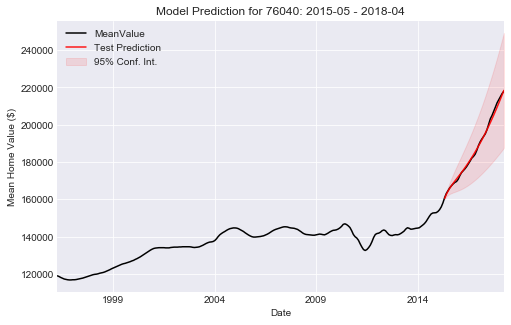

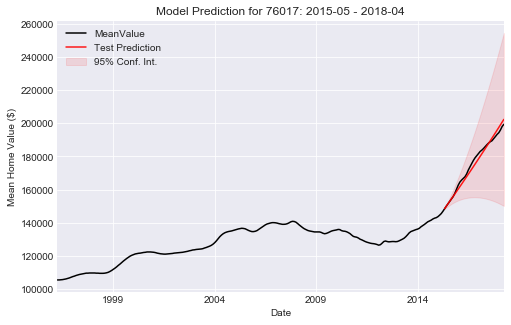

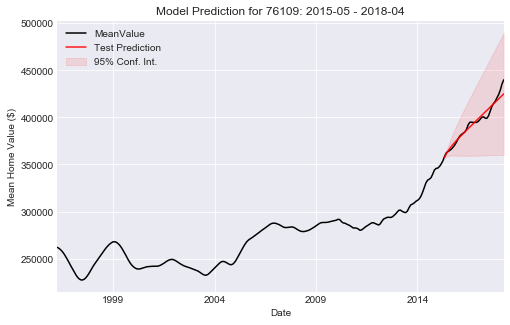

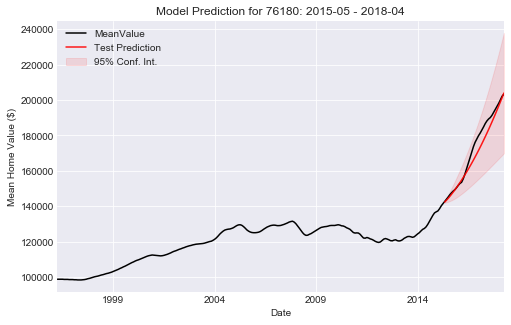

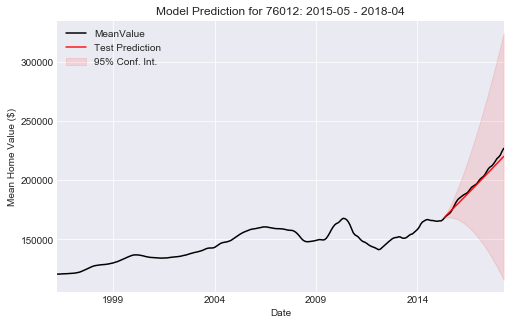

In [13]:
# Get the arima prediction graphs for the top 5 zip codes
for i, row in top_5_zips.iterrows():
    predict_arima(df=df_melted, zip_code=int(i), train_end='2015-04', test_begin='2015-05', test_end='2018-04', 
                  pdq=row['pdq'], plot=True)

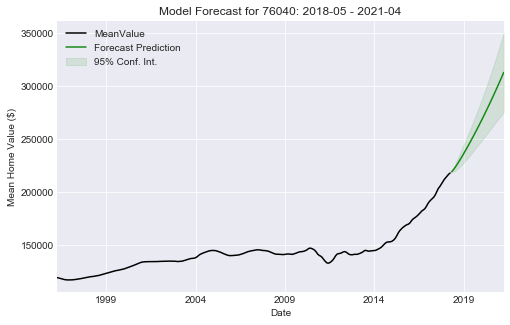

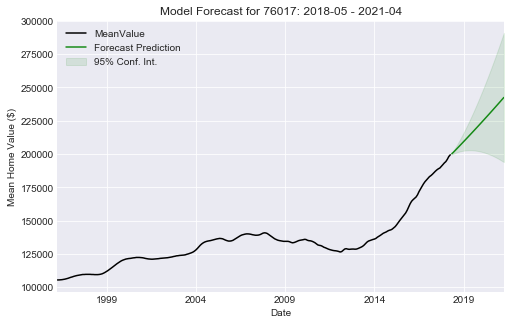

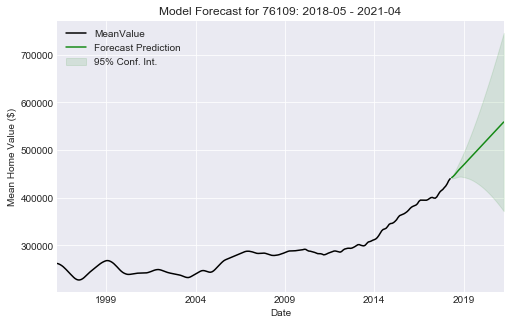

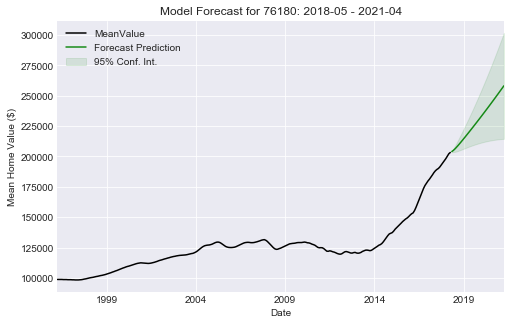

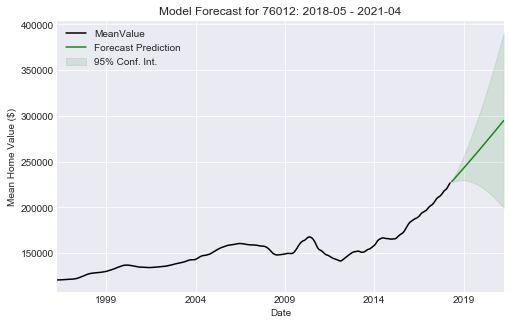

In [14]:
# Get the 3 year arima forecasts for the top 5 zip codes
for i, row in top_5_zips.iterrows():
    forecast_arima(df=df_melted, zip_code=int(i), forecast_begin='2018-05', forecast_end='2021-04', 
                   pdq=row['pdq'], plot=True)

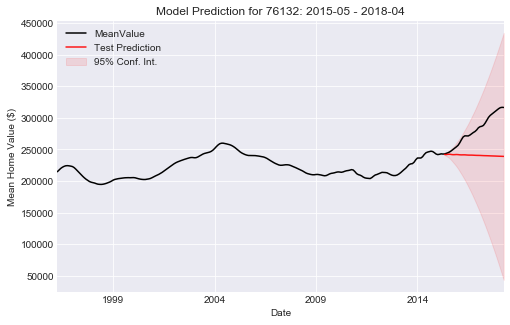

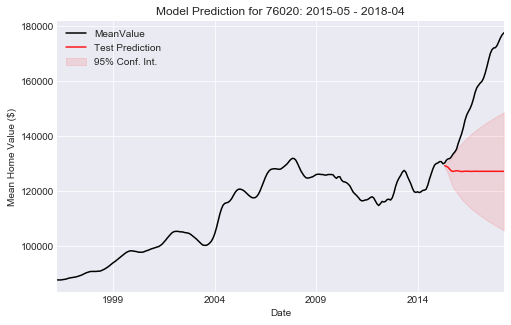

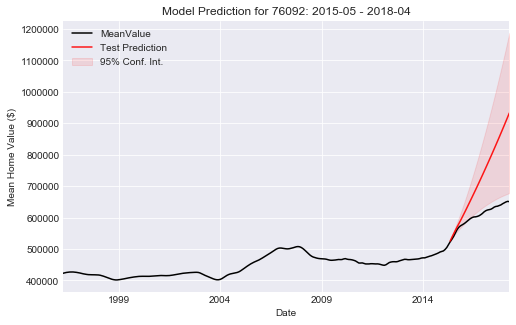

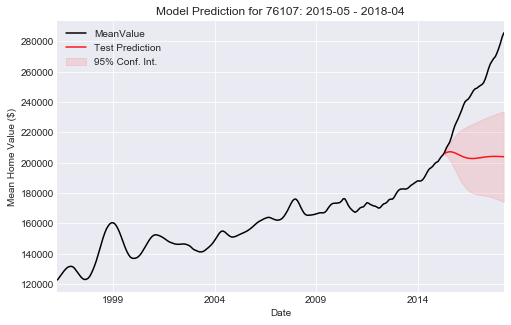

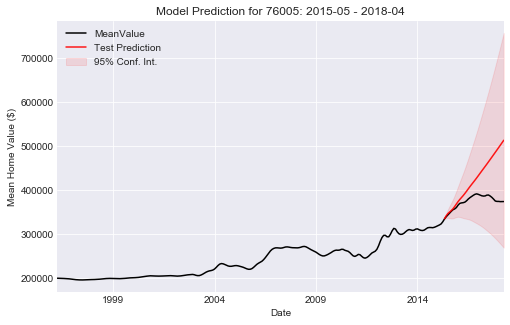

In [15]:
# Get the arima prediction graphs for the worst 5 zip codes
for i, row in worst_5_zips.iterrows():
    predict_arima(df=df_melted, zip_code=int(i), train_end='2015-04', test_begin='2015-05', test_end='2018-04', 
                  pdq=row['pdq'], plot=True)

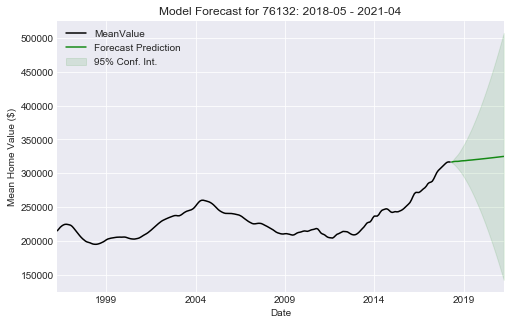

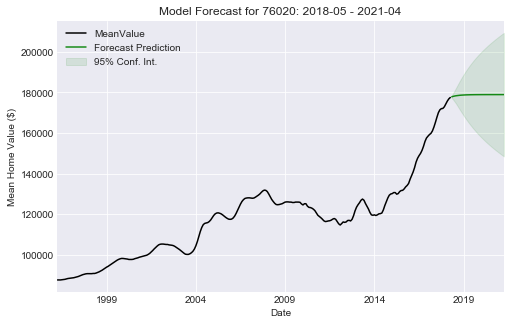

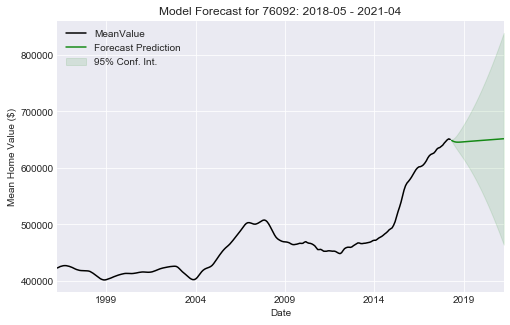

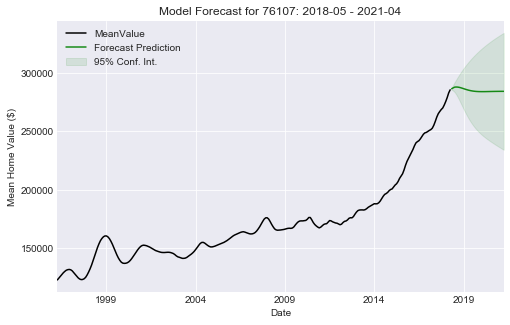

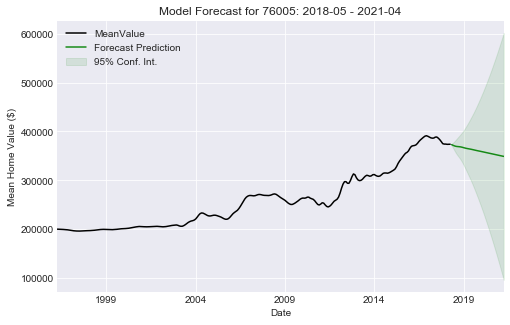

In [16]:
# Get the 3 year arima forecasts for the top 5 zip codes
for i, row in worst_5_zips.iterrows():
    forecast_arima(df=df_melted, zip_code=int(i), forecast_begin='2018-05', forecast_end='2021-04', 
                   pdq=row['pdq'], plot=True)